## 0. Install Dependencies

In [1]:
#pip install -r requirements.txt

## 1. Data Acquisition & Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

# load dataset
df = pd.read_csv("data/data.csv")

In [3]:
# check for rows with missing values or rows with duplicates
missing = df.isnull().sum().sum()
duplicates = df.duplicated().sum()

print(f"Number of missing rows: {missing}\nNumber of duplicate rows: {duplicates}")

Number of missing rows: 0
Number of duplicate rows: 0


## 2. Exploratory Data Analysis (EDA) & Preprocessing

### 2-1. Define audio features
To use the k-Nearest Neighbors (kNN) algorithm, we selected features that **quantitatively** characterize a track's "musical identity". `valence`, `energy`, `danceability`, `acousticness` defines mood and atmosphere. `tempo`, `loudness`, `instrumentalness` defines rhythm and intensity. `year`, `popularity` provides contextual information. 

During the Exploratory Data Analysis (EDA), we identified a subset of data (196 rows) containing zero values for `valence` and `tempo`. We determined these zero values as corrupted data or extraction errors. Since they constitute a negligible portion of the dataset (< 0.12%), we removed these rows to prevent them from distorting the distance calculations in the kNN model.

We retained rows with zero values for `acousticness`, `instrumentalness`, and `popularity` because, unlike tempo or valence where zero indicates data corruption, these zeros carry valid semantic meaning. A value of 0 in acousticness or instrumentalness correctly identifies tracks that are purely electronic or vocal-heavy, while a 0 in popularity represents new or niche releases essential for solving the "cold start" problem.

In [4]:
# print df info to view available columns and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [5]:
# audio features
audio_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
    'popularity', 'year'
]

af = df[audio_features]

print("Audio Features Statistics:")
af.describe().T

Audio Features Statistics:


,count,mean,std,min,25%,50%,75%,max
acousticness,170653.0,0.502115,0.376032,0.0,0.1020,0.516000,0.8930,0.996
danceability,170653.0,0.537396,0.176138,0.0,0.4150,0.548000,0.6680,0.988
energy,170653.0,0.482389,0.267646,0.0,0.2550,0.471000,0.7030,1.000
instrumentalness,170653.0,0.167010,0.313475,0.0,0.0000,0.000216,0.1020,1.000
liveness,170653.0,0.205839,0.174805,0.0,0.0988,0.136000,0.2610,1.000
loudness,170653.0,-11.467990,5.697943,-60.0,-14.6150,-10.580000,-7.1830,3.855
speechiness,170653.0,0.098393,0.162740,0.0,0.0349,0.045000,0.0756,0.970
tempo,170653.0,116.861590,30.708533,0.0,93.4210,114.729000,135.5370,243.507
valence,170653.0,0.528587,0.263171,0.0,0.3170,0.540000,0.7470,1.000
popularity,170653.0,31.431794,21.826615,0.0,11.0000,33.000000,48.0000,100.000


In [6]:
# remove corrupted rows
# 'tempo', 'danceability', and 'energy' columns also have 0s, but are a subset of rows with valence == 0
af = af[af['valence']>0]
print("Audio Features Statistics:")
af.describe().T

Audio Features Statistics:


,count,mean,std,min,25%,50%,75%,max
acousticness,170457.0,0.501973,0.375983,0.00000,0.1010,0.516000,0.8930,0.996
danceability,170457.0,0.537861,0.175504,0.05510,0.4160,0.548000,0.6680,0.988
energy,170457.0,0.482773,0.267435,0.00002,0.2550,0.471000,0.7040,1.000
instrumentalness,170457.0,0.166593,0.313103,0.00000,0.0000,0.000214,0.1000,1.000
liveness,170457.0,0.205770,0.174692,0.00967,0.0988,0.136000,0.2610,1.000
loudness,170457.0,-11.451778,5.662553,-54.83700,-14.6000,-10.573000,-7.1810,3.744
speechiness,170457.0,0.098445,0.162767,0.02220,0.0349,0.045000,0.0757,0.970
tempo,170457.0,116.959970,30.532683,30.94600,93.4860,114.767000,135.5670,243.507
valence,170457.0,0.529195,0.262711,0.00001,0.3180,0.540000,0.7470,1.000
popularity,170457.0,31.435969,21.816283,0.00000,11.0000,33.000000,48.0000,100.000


### 2-2. Feature Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
af_scaled_np = scaler.fit_transform(af)
af_scaled = pd.DataFrame(af_scaled_np, columns=af.columns, index=af.index)
af_scaled

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,year
0,1.276731,-1.474963,-1.016223,2.272127,2.628809,-1.526564,-0.379963,-1.179263,-1.788261,-1.257595,-2.153808
1,0.611805,1.601900,-0.530122,-0.532074,-0.262005,-0.174696,1.944836,-1.834891,1.651266,-1.211758,-2.153808
2,1.220877,-1.195766,-1.184488,2.383912,-0.599744,-0.600124,-0.396551,-0.216849,-1.864391,-1.211758,-2.153808
3,1.236836,-1.497755,-0.649778,-0.531985,1.003084,0.377177,-0.387335,-0.551901,-1.386298,-1.303433,-2.153808
4,1.210239,-0.682956,-1.083529,-0.532068,0.132977,0.239429,-0.371361,-0.500939,-1.051328,-1.349270,-2.153808
...,...,...,...,...,...,...,...,...,...,...,...
170648,-1.110088,1.413870,1.216101,-0.531151,-0.707362,1.368605,-0.063559,-0.390762,0.299969,1.859352,1.668079
170649,-0.787200,1.020715,1.010443,-0.532074,-0.599744,0.959248,-0.233127,0.687005,0.779584,1.676002,1.668079
170650,-1.066469,0.547790,1.403063,-0.532047,0.298984,1.629266,-0.107794,-0.827705,0.410357,2.042702,1.668079
170651,-1.308556,0.758612,0.524343,-0.532050,2.502872,0.757748,1.287454,-1.372467,-1.272104,1.767677,1.668079


# 여기부턴 공사중
남은거: PCA, kNN 구현, 결과 시각화, 모델 성능 평가

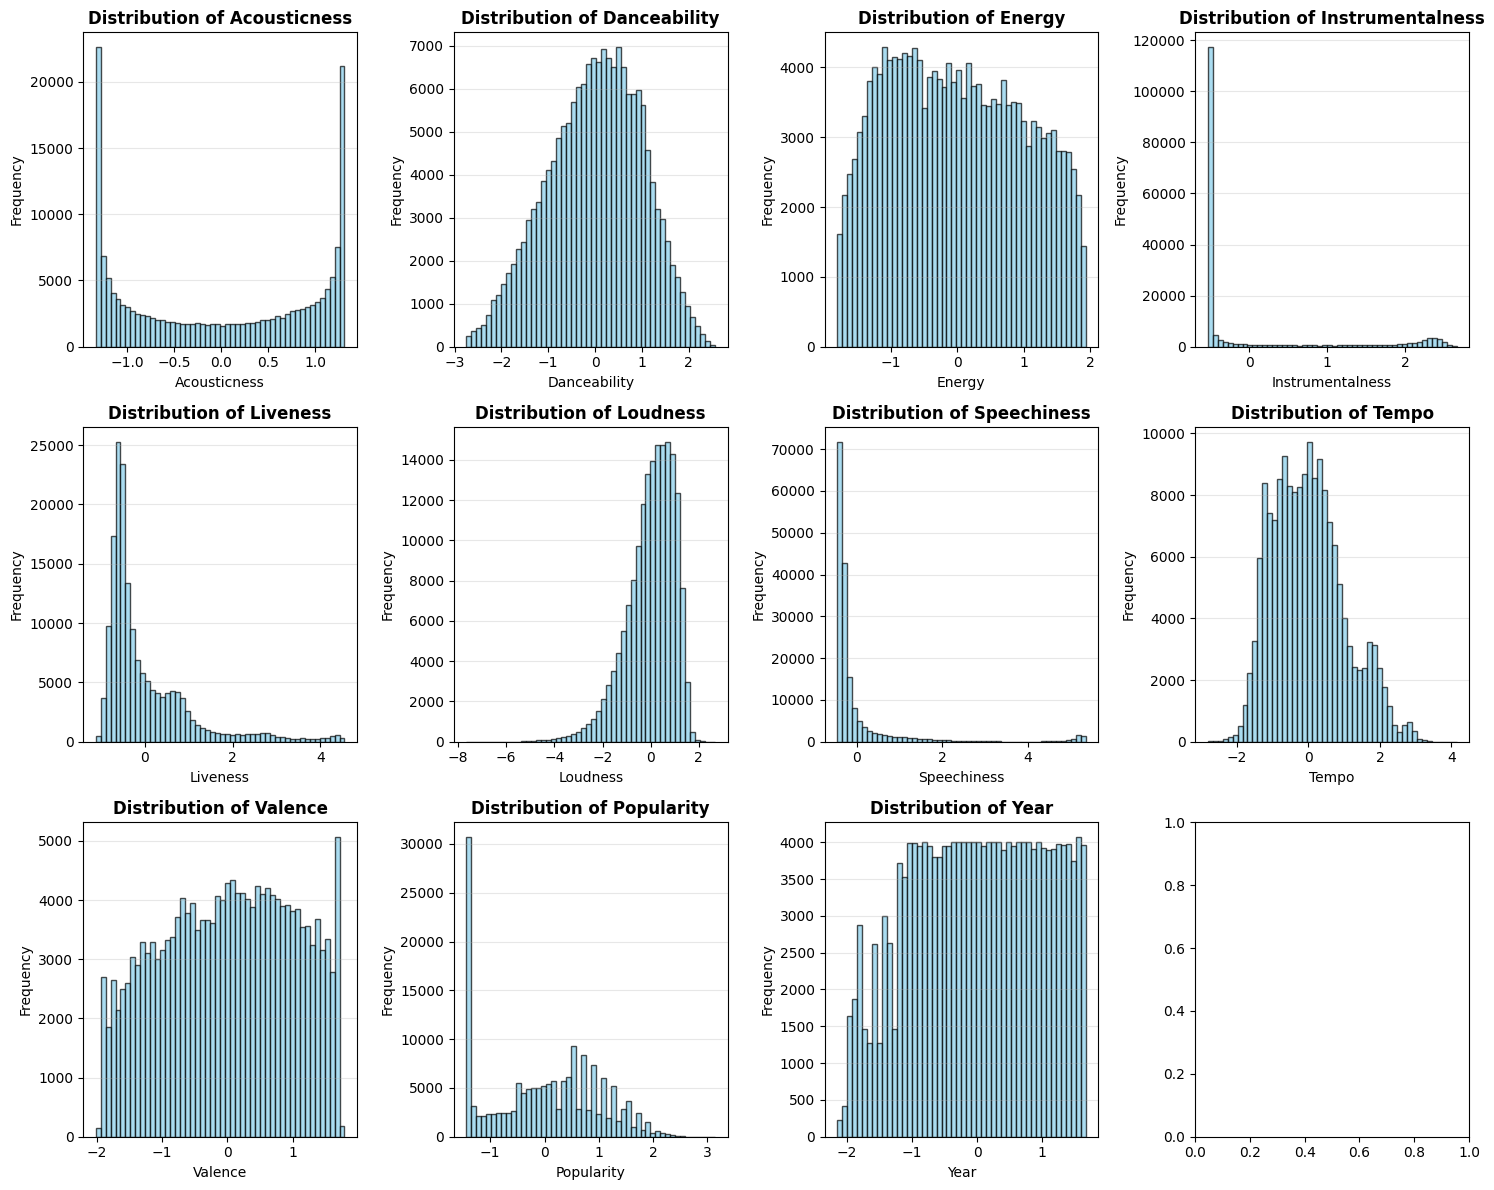

In [8]:
# Plot distributions
# necessary??
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(audio_features):
    axes[idx].hist(af_scaled[feature].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {feature.capitalize()}', fontweight='bold')
    axes[idx].set_xlabel(feature.capitalize())
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

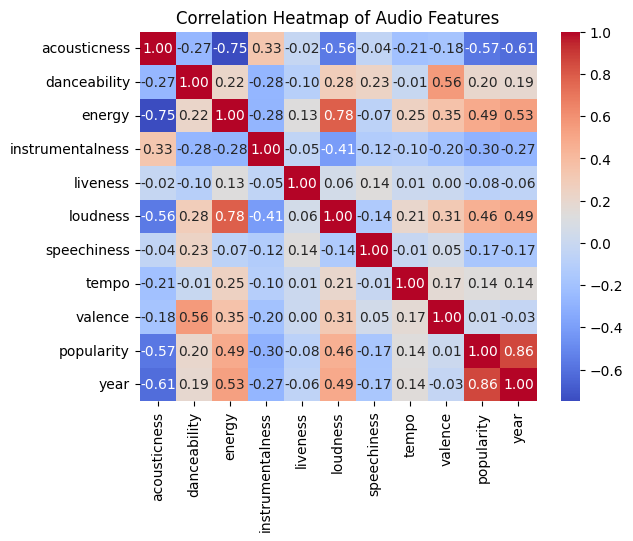

In [9]:
# necessary???
import seaborn as sns

plt.figure()
correlation_matrix = af_scaled[audio_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Audio Features")
plt.show()

In [10]:
print(" Strong Correlations (|r| > 0.5):")
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            strong_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

pd.DataFrame(strong_corr).sort_values('Correlation', ascending=False)

 Strong Correlations (|r| > 0.5):


,Feature 1,Feature 2,Correlation
7,popularity,year,0.862236
5,energy,loudness,0.784123
4,danceability,valence,0.557251
6,energy,year,0.531455
1,acousticness,loudness,-0.564903
2,acousticness,popularity,-0.573570
3,acousticness,year,-0.614659
0,acousticness,energy,-0.750450


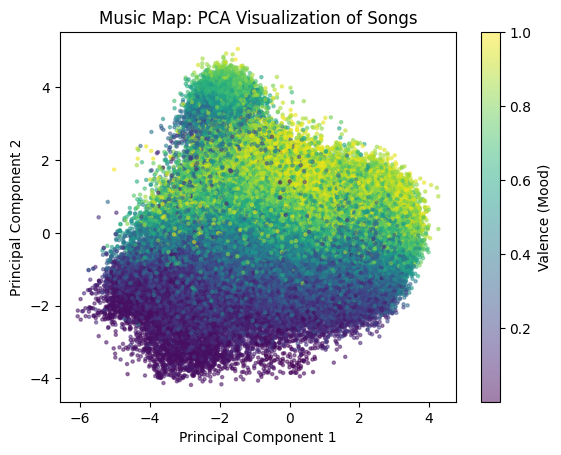

In [11]:
# 1. PCA 모델 생성 (2차원으로 축소)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(af_scaled)

# 2. 시각화 (Scatter Plot)
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=af['valence'], cmap='viridis', s=5, alpha=0.5)
plt.colorbar(label='Valence (Mood)')
plt.title("Music Map: PCA Visualization of Songs")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# 설명: 점 하나가 노래 한 곡입니다.
# 색깔(Valence)은 노래의 밝기(Mood)를 나타냅니다.
# 비슷한 색깔끼리 뭉쳐 있다면, 특징별로 잘 정렬된 것입니다.

Testing different numbers of clusters:
k=2: Inertia=1371931.20, Silhouette=0.254
k=3: Inertia=1219189.57, Silhouette=0.270
k=4: Inertia=1096029.02, Silhouette=0.205
k=5: Inertia=1012781.15, Silhouette=0.161
k=6: Inertia=938857.59, Silhouette=0.166
k=7: Inertia=871684.75, Silhouette=0.171
k=8: Inertia=829225.13, Silhouette=0.164
k=9: Inertia=791979.68, Silhouette=0.165
k=10: Inertia=757231.33, Silhouette=0.157


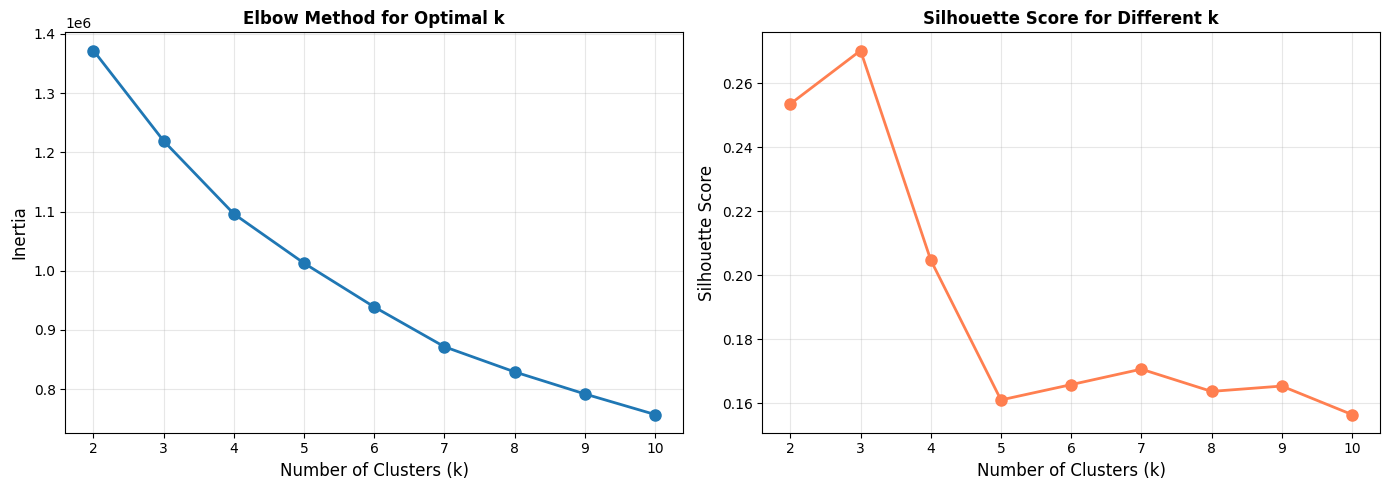


✅ Clustering analysis completed!


In [12]:
# Clustering analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different numbers of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)  # ✅ 2~10으로 줄임

print("Testing different numbers of clusters:")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(af_scaled_np)  # ✅ numpy array 사용
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score (on a sample for speed)
    sample_size = min(10000, len(af_scaled_np))  # ✅ 통일
    sample_idx = np.random.choice(len(af_scaled_np), sample_size, replace=False)
    silhouette = silhouette_score(af_scaled_np[sample_idx], kmeans.labels_[sample_idx])
    silhouette_scores.append(silhouette)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette:.3f}")

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
ax1.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontweight='bold')
ax1.grid(alpha=0.3)

# Silhouette scores
ax2.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score for Different k', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Clustering analysis completed!")